In [134]:
import pandas as pd
from pandas_datareader import data as pdr
import numpy as np
import datetime as dt

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs 
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl

import warnings

Getting Data

In [35]:
tickers = ['RELIANCE.NS','HDFCBANK.BO', 'INFY.BO', 'HINDUNILVR.BO']
# raw adjusted close prices
data = pdr.get_data_yahoo(tickers, start=dt.date.today()-dt.timedelta(500), end=dt.date.today())['Adj Close']
# log returns
log_rets = np.log(data/data.shift(1)).dropna()

# Stationarity
Conditions:
1. The mean of the series should not be a function of time.
2. The variance of the series should not be a function of time. This is also known as 'Homoskedasticity'.
3. The coveriance of the n th term and (n + m) th term should not be a function of time.

Why Stationarity?
1. A stationary time series (TS) is simple to predict as we can assume that future statistical properties are the same or proportional to current statistical properties.
2. Descriptive statistics predicted by these models such as means, variances, and correlations, are only reliable if the Time Series is stationary.

# Serial Correlation (Autocorrelation)
1. Represents the degree of similarity between a given time series and a lagged version of itself over successive time intervals
2. Measures the relationship between a variable's current value and its past values
3. Technical analysts can use autocorrelation to see how much of an impact past prices for a security have on its future price

<> Correlation between a time series and a delayed copy of itself.
<> Ignoring autocorrelation will mean model predictions will be bunk, and one is likely to draw incorrect conclusions about the impact of the independent variables in our model

Why autocorrelation?
1. To detect non-randomness in data
2. To identify an appropriate time series model if the data are not random

The autocorrelation plot can help provide answers to the following questions:
1. Are the data random?
2. Is an observation related to an adjacent observation?
3. Is an observation related to an observation twice-removed? (etc.)
4. Is the observed time series white noise?
5. Is the observed time series sinusoidal?
6. Is the observed time series autoregressive?

# Partial Autocorrelation
1. Partial correlation of a stationary time series with its own lagged values, regressed the values of the time series at all shorter lags
2. It contrasts with the autocorrelation function, which does not control for other lags

<> Removes effect of previous time points
a partial autocorrelation function of order 3 returns the correlation between our time series (t_1, t_2, t_3, …) and its own values lagged by 3 time points (t_4, t_5, t_6, …), but only after removing all effects attributable to lags 1 and 2.
<> The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags.

The partial autocorrelation plot can help provide answers to the following questions:
1. Is an AR model appropriate for the data?
2. If an AR model is appropriate, what order should we use?

# White Noise and Random Walks
<> A time series is white noise if the variables are independent and identically distributed (i.i.d) with a mean of zero

Meaning that all variables have the same variance (sigma^2) and each value has a zero correlation with all other values in the series

White Noises are stationary.

<> A random walk is another time series model where the current observation is equal to the previous observation with a random step up or down.

Random walk are non stationary.

time series model xt = xt-1 + wt; wt is a discrete white noise series

In [54]:
def time_series_plot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)                      #convert into series first, if not already
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

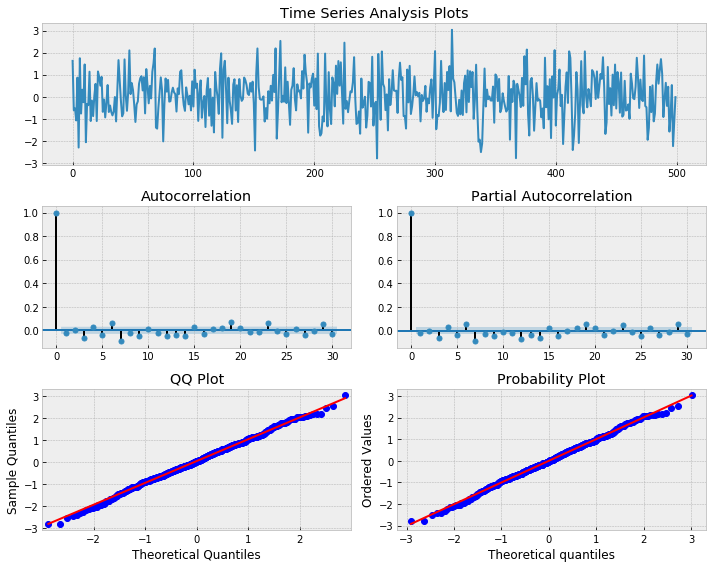

In [47]:
np.random.seed(1)

# plot of discrete white noise
randser = np.random.normal(size=500)
time_series_plot(randser, lags=30)

In [38]:
print("Random Series\n-------------\nmean: {:.3f}\nvariance: {:.3f}\nstandard deviation: {:.3f}"
.format(randser.mean(), randser.var(), randser.std()))

Random Series
-------------
mean: 0.053
variance: 0.977
standard deviation: 0.988


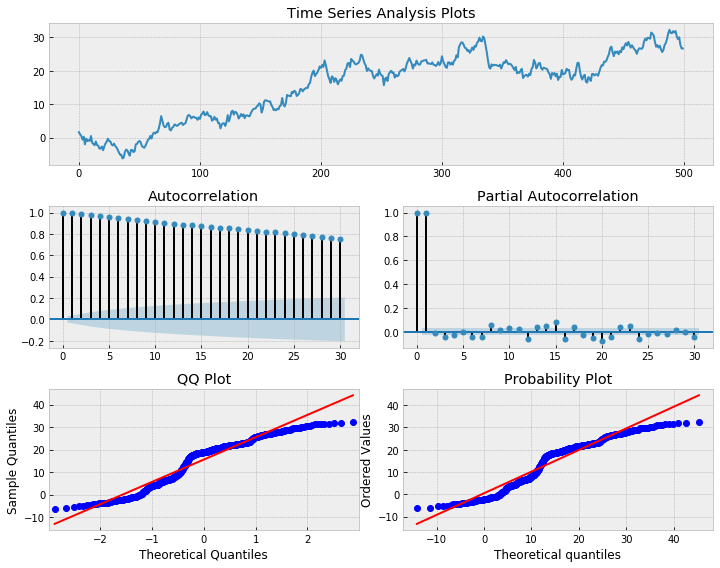

In [46]:
np.random.seed(1)
n_samples = 500

x = w = np.random.normal(size=n_samples)
for t in range(n_samples):
    x[t] = x[t-1] + w[t]          #Random Walk without a drift

_ = time_series_plot(x, lags=30)

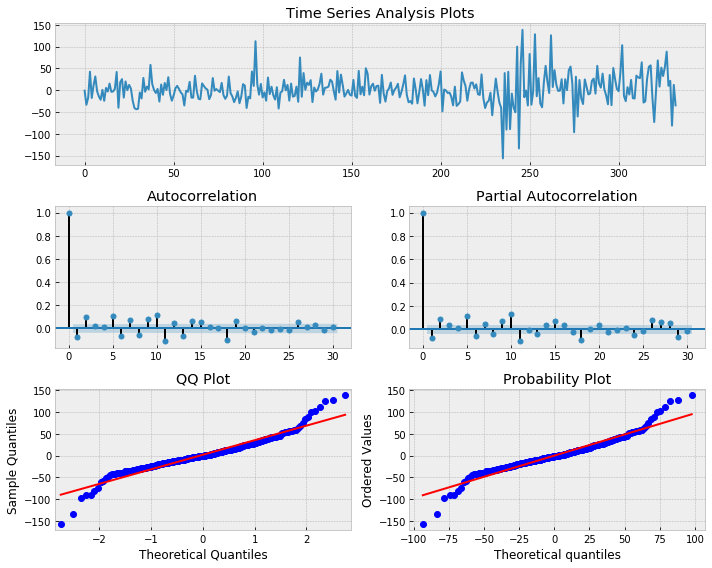

In [142]:
# First difference of RELIANCE prices
_ = time_series_plot(np.diff(data['RELIANCE.NS']), lags=30)

# Autoregressive Models - AR(p)
When the dependent variable is regressed against one or more lagged values of itself the model is called autoregressive.

"order" of the model, as in, an AR model of order "p", the p represents the number of lagged variables used within the model

yt = φ1yt-1 + φ2yt-2 + … + φpyt-p + wt

yt-1, yt-2…yt-p are the past series values (lags),
wt is white noise (i.e. randomness)

<> AR(1) model with φ set equal to 1 is a random walk and therefore not stationary.

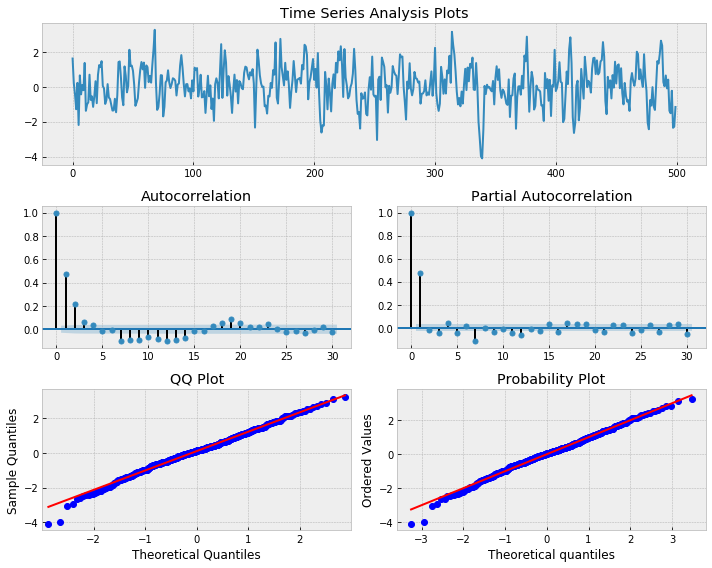

In [58]:
# Simulate an AR(1) process with alpha = 0.5

np.random.seed(1)
n_samples = int(500)
φ = 0.5
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = φ*x[t-1] + w[t]
    
_ = time_series_plot(x, lags=30)

In [77]:
#using Python's statsmodels function "select_order()" to see if the fitted model will select the correct lag

#fit an AR(p) model to simulated AR(1) model with alpha = 0.5

mdl = smt.AR(x).fit(maxlag=30, ic='aic', trend='nc')     
#ic: information criteria, trend: Whether to include a constant or not
est_order = smt.AR(x).select_order(maxlag=30, ic='aic', trend='nc')

true_order = 1
print('\nφ estimate: {:3.5f} | best lag order = {}'.format(mdl.params[0], est_order))
print('\ntrue φ = {} | true order = {}'.format(φ, true_order))


φ estimate: 0.47952 | best lag order = 1

true φ = 0.5 | true order = 1


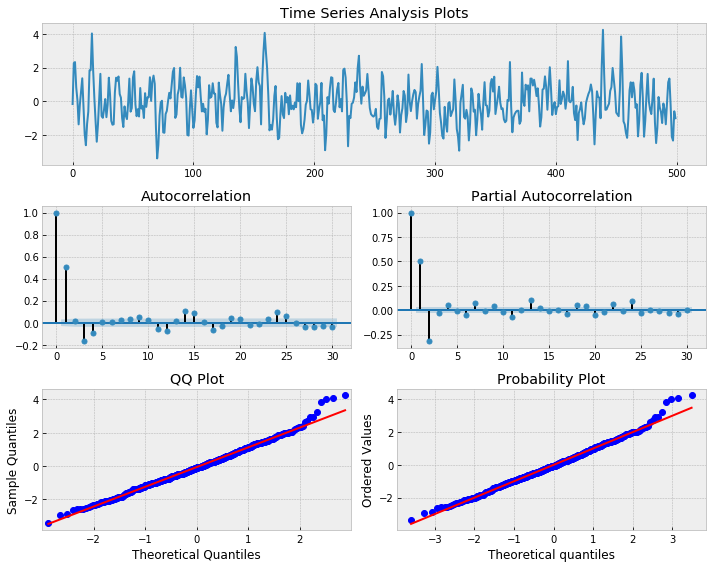

In [127]:
#simulating an AR(2) process

n = int(500)
φs = np.array([.666, -.333])
betas = np.array([0.])  #Set betas zero to make MA equal to 0

ar = np.r_[1, -φs]
ma = np.r_[1, betas]
#np.r_ : row wise merging

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = time_series_plot(ar2, lags=30)

In [85]:
#fitting an AR(p) model to simulated AR(2) process

max_lag = 10
mdl = smt.AR(ar2).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(ar2).select_order(maxlag=max_lag, ic='aic', trend='nc')

true_order = 2
print('\ncoef estimate: {:3.4f} {:3.4f} | best lag order = {}'.format(mdl.params[0],mdl.params[1], est_order))
print('\ntrue coefs = {} | true order = {}'.format([.666,-.333], true_order))


coef estimate: 0.6704 -0.3386 | best lag order = 2

true coefs = [0.666, -0.333] | true order = 2


# Moving Average Models - MA(q)
The difference between AR and MA is that the MA(q) model is a linear combination of past white noise error terms as opposed to a linear combination of past observations like the AR(p) model

MA model observe "shocks" in the error, processes directly by fitting a model to the error terms.

xt = wt + β1*wt-1 + .... + βp*wt-p

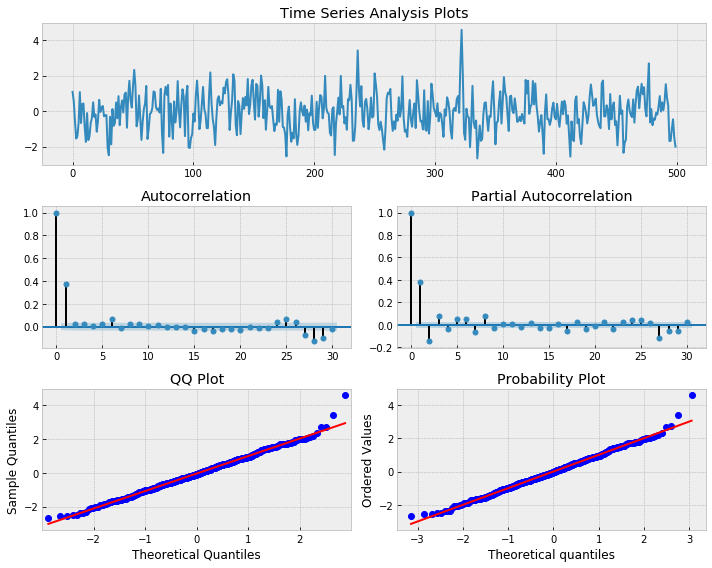

In [109]:
#simulating an MA(1) process

n = int(500)

#set the AR(p) alphas equal to 0
φs = np.array([0.])
betas = np.array([0.5])

#add zero-lag and negate alphas
ar = np.r_[1, -φs]
ma = np.r_[1, betas]

ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = time_series_plot(ma1, lags=30)

In [110]:
#fitting the MA(1) model to our simulated time series
#specify ARMA model with order (p, q)

max_lag = 30
mdl = smt.ARMA(ma1, order=(0, 1)).fit(maxlag=max_lag, method='mle', trend='nc') 
#mle = Maximum Likelihood Estimation
#MLE is the technique which helps us in determining the parameters of the distribution that best describe the given data.
print(mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  500
Model:                     ARMA(0, 1)   Log Likelihood                -680.757
Method:                           mle   S.D. of innovations              0.944
Date:                Fri, 31 Jul 2020   AIC                           1365.514
Time:                        17:50:13   BIC                           1373.943
Sample:                             0   HQIC                          1368.822
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.4452      0.039     11.394      0.000       0.369       0.522
                                    Roots                                    
                  Real          Imaginary           M

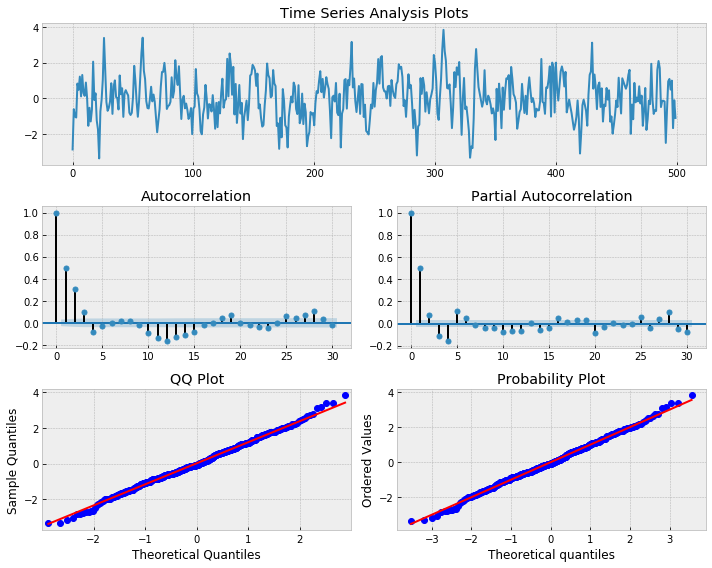

In [123]:
#simulating MA(3) process with betas 0.5, 0.4, 0.2

n = int(500)
φs = np.array([0.])
betas = np.array([0.5, 0.4, 0.2])
ar = np.r_[1, -φs]
ma = np.r_[1, betas]

ma3 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
_ = time_series_plot(ma3, lags=30)

In [124]:
#fitting MA(3) model to simulated time series

max_lag = 30
mdl = smt.ARMA(ma3, order=(0, 3)).fit(maxlag=max_lag, method='mle', trend='nc')
print(mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  500
Model:                     ARMA(0, 3)   Log Likelihood                -707.007
Method:                           mle   S.D. of innovations              0.995
Date:                Fri, 31 Jul 2020   AIC                           1422.014
Time:                        18:02:16   BIC                           1438.873
Sample:                             0   HQIC                          1428.630
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.4885      0.044     10.991      0.000       0.401       0.576
ma.L2.y        0.4112      0.047      8.741      0.000       0.319       0.503
ma.L3.y        0.2530      0.045      5.683      0.0

In [125]:
#Conditional Mean Model	  ACF                    PACF
#                 AR(p)	  Tails off gradually    Cuts off after p lags
#                 MA(q)	  Cuts off after q lags  Tails off gradually
#             ARMA(p,q)	  Tails off gradually    Tails off gradually

/Users/aayush/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:            RELIANCE.NS   No. Observations:                  333
Model:                     ARMA(0, 3)   Log Likelihood                 743.474
Method:                           mle   S.D. of innovations              0.026
Date:                Sat, 01 Aug 2020   AIC                          -1478.947
Time:                        12:31:30   BIC                          -1463.715
Sample:                             0   HQIC                         -1472.873
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
ma.L1.RELIANCE.NS    -0.1413      0.055     -2.578      0.010      -0.249      -0.034
ma.L2.RELIANCE.NS     0.1006      0.055      1.838      0.066      -0.007       0.208
ma.L3.RELIANCE.NS     0.

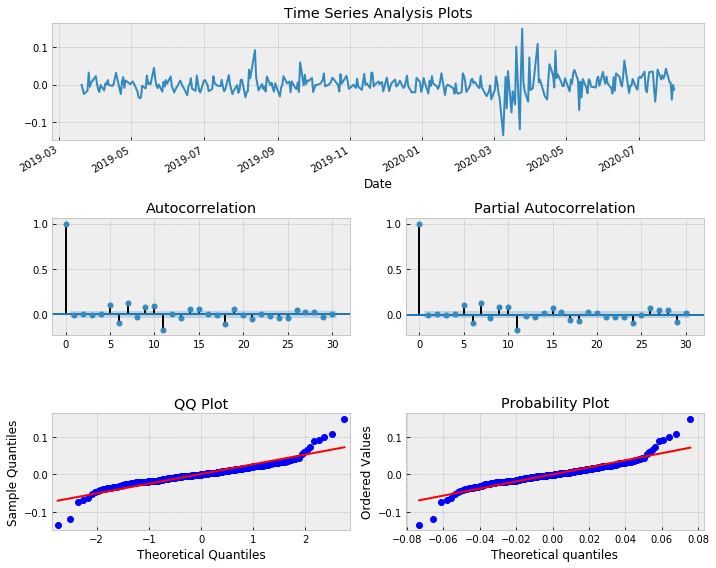

In [143]:
#fitting MA(3) to RELIANCE returns

max_lag = 30
Y = log_rets['RELIANCE.NS']
mdl = smt.ARMA(Y, order=(0, 3)).fit(maxlag=max_lag, method='mle', trend='nc')
print(mdl.summary())
_ = time_series_plot(mdl.resid, lags=max_lag)

# Autoregressive Moving Average Models - ARMA(p, q)
AR(p) models try to capture (explain) the momentum and mean reversion effects often observed in trading markets.

MA(q) models try to capture (explain) the shock effects observed in the white noise terms. These shock effects could be thought of as unexpected events affecting the observation process

xt = φ1yt-1 + φ2yt-2 + … + φpyt-p + wt + β1*wt-1 + .... + βp*wt-p

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 5000
Model:                     ARMA(2, 2)   Log Likelihood               -7089.596
Method:                           mle   S.D. of innovations              0.999
Date:                Fri, 31 Jul 2020   AIC                          14189.192
Time:                        18:08:56   BIC                          14221.778
Sample:                             0   HQIC                         14200.613
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.4389      0.064      6.908      0.000       0.314       0.563
ar.L2.y       -0.2195      0.015    -14.359      0.000      -0.249      -0.190
ma.L1.y        0.5272      0.065      8.160      0.0

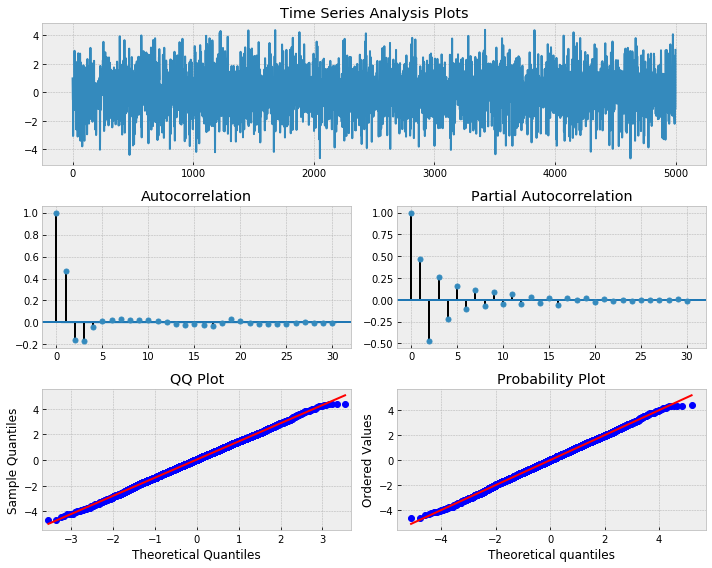

In [128]:
#simulating an ARMA(2, 2) model with φs=[0.5,-0.25] and betas=[0.5,-0.3]
max_lag = 30

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

φs = np.array([0.5, -0.25])
betas = np.array([0.5, -0.3])
ar = np.r_[1, -φs]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = time_series_plot(arma22, lags=max_lag)

mdl = smt.ARMA(arma22, order=(2, 2)).fit(maxlag=max_lag, method='mle', trend='nc', burnin=burn)
print(mdl.summary())

aic: 14182.82976 | order: (3, 2)


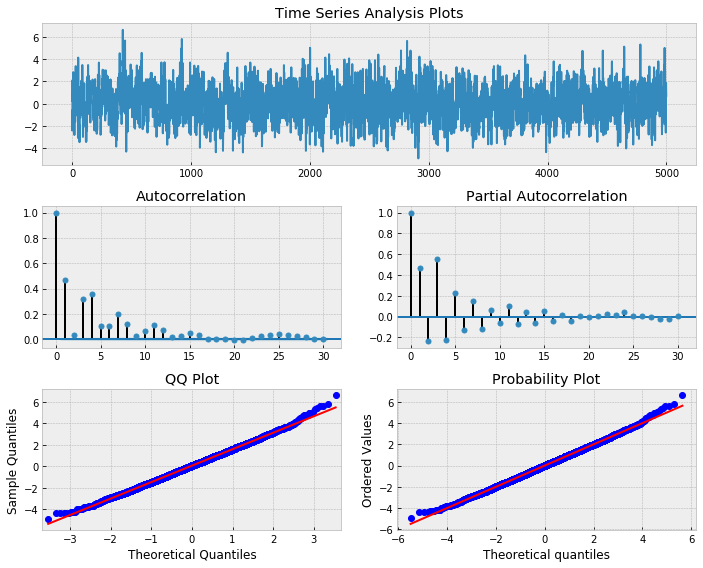

In [129]:
#simulating an ARMA(3, 2) model with alphas=[0.5,-0.25,0.4] and betas=[0.5,-0.3]

max_lag = 30

n = int(5000)
burn = 2000

φs = np.array([0.5, -0.25, 0.4])
betas = np.array([0.5, -0.3])

ar = np.r_[1, -φs]
ma = np.r_[1, betas]

arma32 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = time_series_plot(arma32, lags=max_lag)

#pick best order by aic 
#smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(arma32, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

In [131]:
#fitting ARMA model to RELIANCE returns

best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5) 
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(log_rets['RELIANCE.NS'], order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

/Users/aayush/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/aayush/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/aayush/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/aayush/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but 

aic: -1487.01486 | order: (3, 3)


/Users/aayush/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


/Users/aayush/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


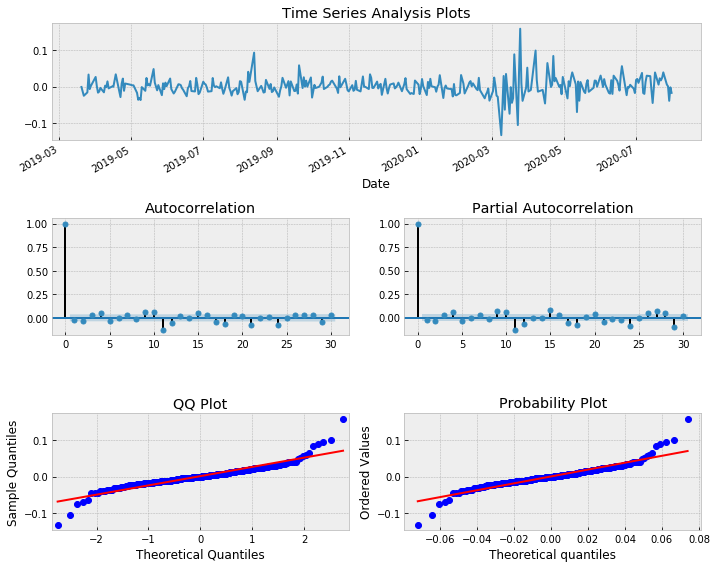

In [138]:
#plotting model residuals with ARMA (3,3)
tmp_mdl = smt.ARMA(log_rets['RELIANCE.NS'], order=(3, 3)).fit(method='mle', trend='nc')
_ = time_series_plot(tmp_mdl.resid, lags=max_lag)

# Autoregressive Integrated Moving Average Models - ARIMA(p, d, q)
Many of the time series are not stationary. But can be made stationary by differencing them.
Here, d = number of times of differencing the series

The best ARIMA model to fit RELIANCE returns can be found by defining p,d,q. 

Use the AIC to evaluate each model. 

The lowest AIC wins. 

In [140]:
#fitting ARIMA(p, d, q) model to RELIANCE Returns
#will pick best order and final model based on aic

best_aic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(5) # [0,1,2,3,4]
d_rng = range(2) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(log_rets['RELIANCE.NS'], order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))



/Users/aayush/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/aayush/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/aayush/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/aayush/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but 

aic: -1487.01486 | order: (3, 0, 3)


/Users/aayush/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/aayush/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/aayush/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/aayush/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but 

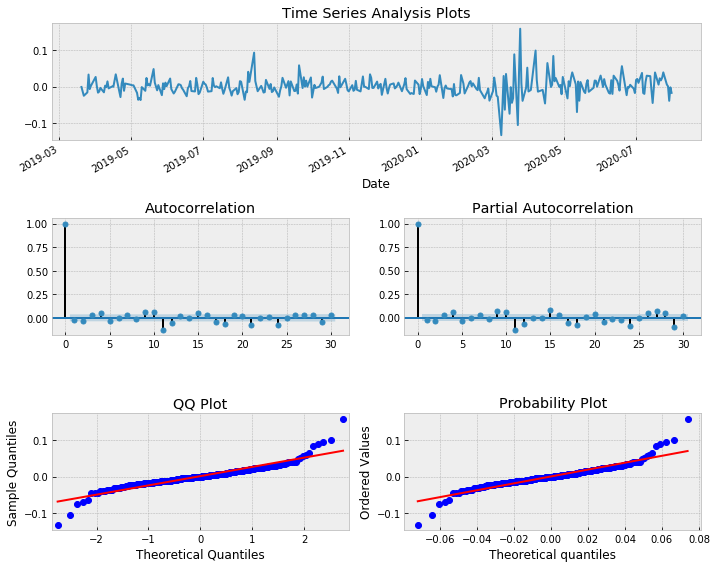

In [141]:
#RESULT: aic: -1487.01486 | order: (3, 0, 3)

# ARIMA model resid plot
_ = time_series_plot(best_mdl.resid, lags=30)

In [151]:
#FORECASTING
#The default setting is 95% confidence. For 99% set alpha equal to 0.01 in the code.

#creating a 21 day forecast of RELIANCE returns with 95%, 99% Confidence interval
n_steps = 21

f, err95, ci95 = best_mdl.forecast(steps=n_steps) #95% Confidence interval
_, err99, ci99 = best_mdl.forecast(steps=n_steps, alpha=0.01) #99% Confidence interval

idx = pd.date_range(data.index[-1], periods=n_steps, freq='D')

fc_95 = pd.DataFrame(np.column_stack([f, ci95]), index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([ci99]), index=idx, columns=['lower_ci_99', 'upper_ci_99'])

fc_all = fc_95.combine_first(fc_99)

fc_all.head()

,forecast,lower_ci_95,lower_ci_99,upper_ci_95,upper_ci_99
2020-07-31,-0.000075,-0.049848,-0.065487,0.049697,0.065336
2020-08-01,0.004969,-0.044972,-0.060665,0.054911,0.070603
2020-08-02,-0.006155,-0.056374,-0.072155,0.044065,0.059845
2020-08-03,0.007303,-0.042936,-0.058722,0.057542,0.073328
2020-08-04,-0.005069,-0.055324,-0.071116,0.045187,0.060979


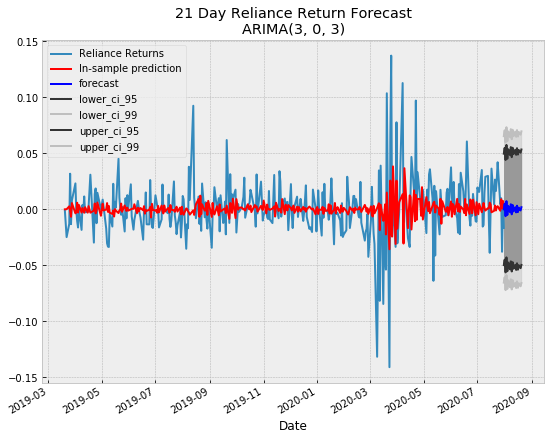

In [152]:
#plotting 21 day forecast for RELIANCE returns

plt.style.use('bmh')
fig = plt.figure(figsize=(9,7))
ax = plt.gca()

ts = log_rets['RELIANCE.NS'].iloc[-500:].copy()
ts.plot(ax=ax, label='Reliance Returns')

# in sample prediction
pred = best_mdl.predict(ts.index[0], ts.index[-1])
pred.plot(ax=ax, style='r-', label='In-sample prediction')

styles = ['b-', '0.2', '0.75', '0.2', '0.75']
fc_all.plot(ax=ax, style=styles)
plt.fill_between(fc_all.index, fc_all.lower_ci_95, fc_all.upper_ci_95, color='gray', alpha=0.7)
plt.fill_between(fc_all.index, fc_all.lower_ci_99, fc_all.upper_ci_99, color='gray', alpha=0.2)
plt.title('{} Day Reliance Return Forecast\nARIMA{}'.format(n_steps, best_order))
plt.legend(loc='best', fontsize=10)

# Autoregressive Conditionally Heteroskedastic Models - ARCH(p) 

ARCH(p) models can be thought of as simply an AR(p) model applied to the variance of a time series


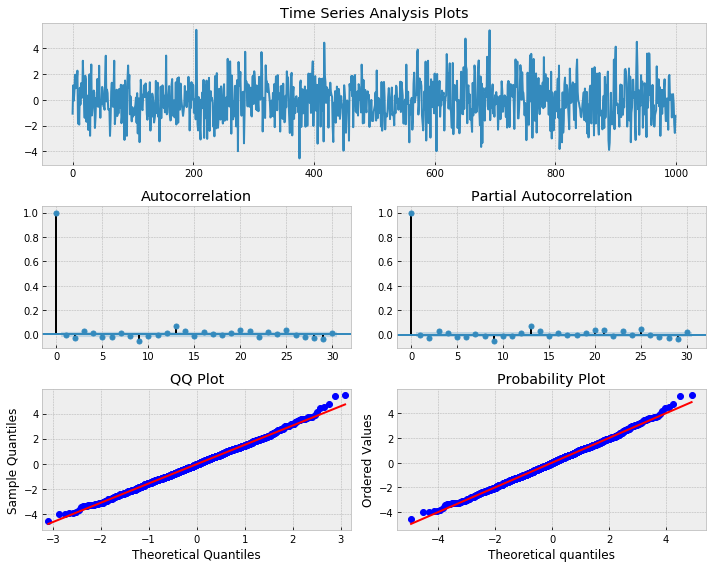

In [154]:
#simulating ARCH(1) series
#Var(yt) = a_0 + a_1*y{t-1}**2
#if a_1 is between 0 and 1 then yt is white noise

np.random.seed(13)

a0 = 2
a1 = .5

y = w = np.random.normal(size=1000)
Y = np.empty_like(y)

for t in range(len(y)):
    Y[t] = w[t] * np.sqrt((a0 + a1*y[t-1]**2))

#simulating ARCH(1) series, looks like white noise
time_series_plot(Y, lags=30)

# Generalized Autoregressive Conditionally Heteroskedastic Models - GARCH(p,q)

GARCH(p, q)  is an ARMA model applied to the variance of a time series i.e., it has an autoregressive term and a moving average term. The AR(p) models the variance of the residuals (squared errors) or simply our time series squared. The MA(q) portion models the variance of the process. 


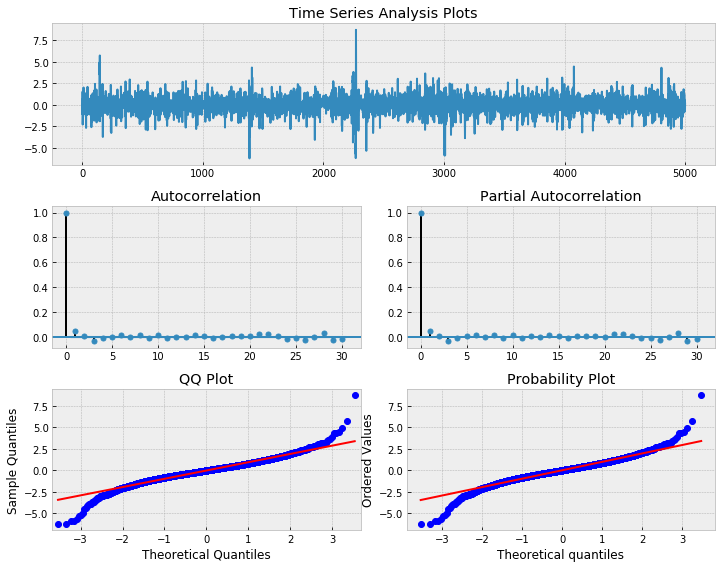

In [155]:
#simulating a GARCH(1, 1) process

np.random.seed(2)

a0 = 0.2
a1 = 0.5
b1 = 0.3

n = 5000
w = np.random.normal(size=n)
eps = np.zeros_like(w)
sigsq = np.zeros_like(w)

for i in range(1, n):
    sigsq[i] = a0 + a1*(eps[i-1]**2) + b1*sigsq[i-1]
    eps[i] = w[i] * np.sqrt(sigsq[i])

_ = time_series_plot(eps, lags=30)

In [157]:
#fitting a GARCH(1, 1) model to our simulated EPS series
#use the arch_model function from the ARCH package

am = arch_model(eps)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     38,   Neg. LLF: 6160.778998203601
Iteration:     10,   Func. Count:     70,   Neg. LLF: 6149.838080115927
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6149.835297101096
            Iterations: 12
            Function evaluations: 82
            Gradient evaluations: 12
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -6149.84
Distribution:                  Normal   AIC:                           12307.7
Method:            Maximum Likelihood   BIC:                           12333.7
                                        No. Observations:                 5000
Date:                Sat, Aug 01 2020   Df Residuals:                     4996
Time:         

# 
Now let's run through an example using RELIANCE returns. The process is as follows:

Iterate through combinations of ARIMA(p, d, q) models to best fit our time series.

Pick the GARCH model orders according to the ARIMA model with lowest AIC.

Fit the GARCH(p, q) model to our time series.

Examine the model residuals and squared residuals for autocorrelation

In [163]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(5) # [0,1,2,3,4]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(method='mle', trend='nc')
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

#select a specific time period to run this analysis
TS = log_rets.iloc[-1000:,0]
res_tup = _get_best_model(TS)

/Users/aayush/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/aayush/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/aayush/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/aayush/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but 

aic: -1487.01486 | order: (3, 0, 3)


/Users/aayush/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/aayush/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/aayush/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/aayush/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but 

In [164]:
#fitting the arch model using the best fit arima model parameters

p_ = best_order[0]
o_ = best_order[1]
q_ = best_order[2]

#Using student T distribution usually provides better fit
am = arch_model(TS, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

/Users/aayush/opt/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006953. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


                        Constant Mean - GARCH Model Results                         
Dep. Variable:                  RELIANCE.NS   R-squared:                      -0.001
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                            GARCH   Log-Likelihood:                818.150
Distribution:      Standardized Student's t   AIC:                          -1618.30
Method:                  Maximum Likelihood   BIC:                          -1584.03
                                              No. Observations:                  333
Date:                      Sat, Aug 01 2020   Df Residuals:                      324
Time:                              13:00:31   Df Model:                            9
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
m